# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
import time
import copy

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/adam/Desktop/pitszi_Mbb/'

In [3]:
#----- Physical model parameters
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec = 30*u.deg, 55*u.deg
axis_q1, axis_q2 = 0.7, 0.8
euler_1, euler_2, euler_3 = 40*u.deg, 50*u.deg, 15*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_seed = 25252

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 18*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_Ntheta500 = 0.5

# Noise
noise_k = lambda k_arcsec: (1e-9 + 3e-9 * (k_arcsec*60)**-1)
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_seed = 24355

In [5]:
#----- Analysis parameters
# Image sampling
los_size = 1*u.Mpc
los_reso = 100*u.kpc

# Pk measurement
Nbins_pk = 30
scale_bins = 'lin'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(beam_FWHM.to('arcsec'))

method_data_deconv = False
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# MCMC
nwalkers = 100
nsteps = 200
burnin = 20
mcmc_reset = True
mcmc_run = True

# Generate mock data

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA, Dec=Dec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}

mock.map_center = SkyCoord(mock.coord.ra, mock.coord.dec, frame="icrs")
mock.map_fov    = [5, 5]*u.arcmin
mock.map_reso  = 5.0*u.arcsec
mock.los_reso  = los_reso
mock.los_size  = los_size
mock.R_truncation = mock.R500*5

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 59 , 59 , 11
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   1855.0   ,   1855.0   ] kpc ; [   4.917    ,   4.917    ] arcmin
   L.o.S. resolution :        100.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.003390  /  0.098305   1/arcsec
   k min/max projected :       0.000539  /  0.015633   1/kpc
   k min/max L.o.S. (eq.) :    0.005717  /  0.028583   1/arcsec
   k min/max L.o.S. :          0.000909  /  0.004545   1/kpc
   k max Nyquist :             0.028583   1/arcsec
   k max Nyquist :             0.004545   1/kpc


In [7]:
#===== Initiate a data object and fake data
#----- Init with the mock
data = pitszi.Data(mock.get_sz_map(), mock.get_map_header())
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model = [noise_r, noise_k]

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, data.header['CRVAL1'], data.header['CRVAL2'])
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
data.mask = mask

#----- Define the noise properties
data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.map_center)
data.noise_rms = data.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)
if os.path.exists(data.output_dir+'/data_image_noise_covariance_matrix.pkl'):
    data.load_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')
else:
    data.get_noise_covariance_from_model(Nmc=1000)
    data.save_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')

#----- Mock the data
img = data.set_image_to_mock(mock, 
                             model_seed=fluct_seed, model_no_fluctuations=False, 
                             noise_origin='model', noise_center=mock.map_center, noise_seed=noise_seed)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  


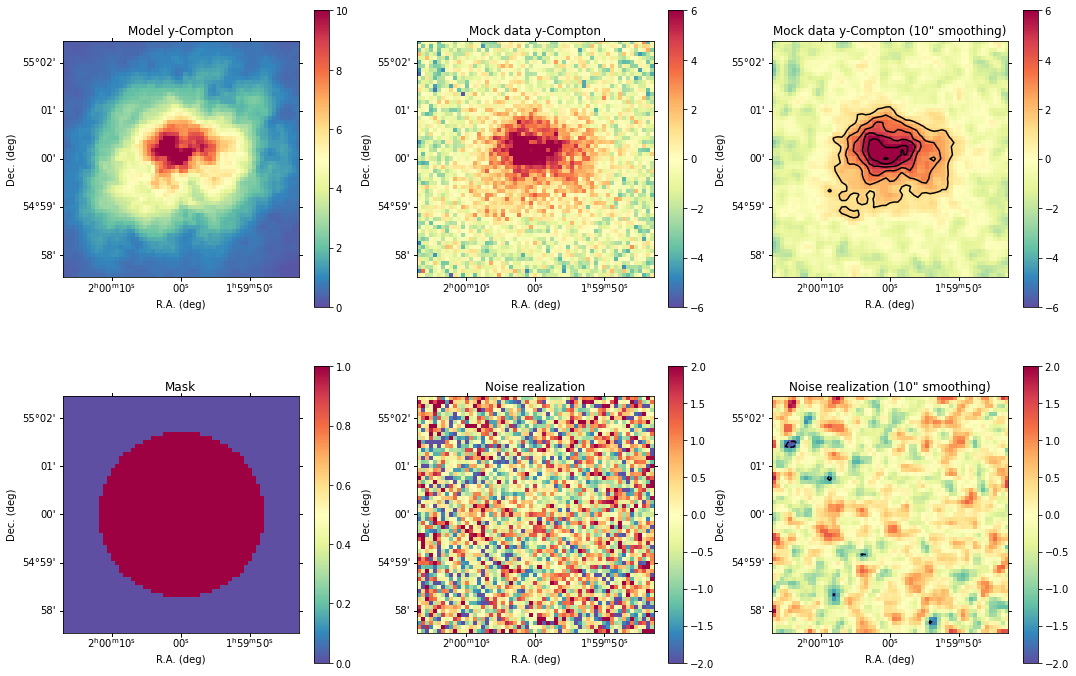

In [8]:
visu_smooth = 10

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 12))

ax = plt.subplot(2, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(seed=fluct_seed, no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data.header))
plt.imshow(data.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data.header))
plt.imshow(data.noise_mc[0]*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Noise realization')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-3,3], colors='k')
plt.title('Noise realization ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Build model to be used in the fit

In [64]:
model = copy.deepcopy(mock)

In [65]:
inference = pitszi.Inference(data, model)

inference.kbin_min   = kmin_pk
inference.kbin_max   = kmax_pk
inference.kbin_Nbin  = Nbins_pk
inference.kbin_scale = scale_bins

inference.mcmc_nwalkers = nwalkers
inference.mcmc_nsteps   = nsteps
inference.mcmc_burnin   = burnin
inference.mcmc_reset    = mcmc_reset
inference.mcmc_run      = mcmc_run
inference.output_dir    = output_dir

inference.method_data_deconv = method_data_deconv
inference.set_method_w8(apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=method_w8_smooth)

inference.setup()

----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 8.  4.  8.  8.  8. 12. 20. 12. 16. 24. 16. 24. 24. 28. 28. 20. 32. 40.
 24. 44. 36. 44. 28. 44. 40. 64. 24. 68. 44. 52.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----


### Check that inference can extract data, model and noise properties to be passed to fitting tools

##### Case of the radial model

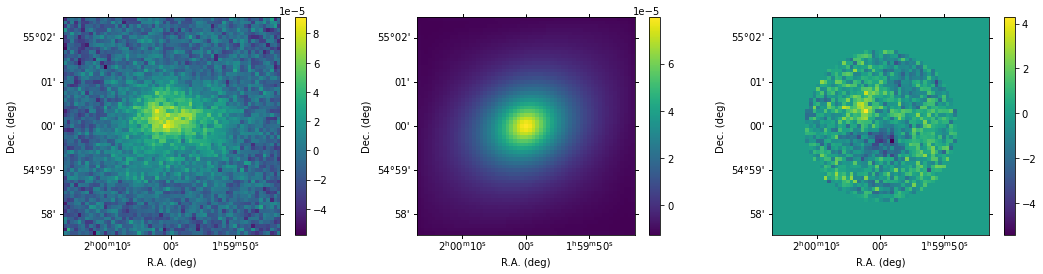

In [11]:
inference.nuisance_ZL = 0
inference.model.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                               'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}
inference.model.model_pressure_profile['P_0'] *= 1

resid = (inference.get_radial_data() - inference.get_radial_model()) / inference.get_radial_noise_statistics()[0]

plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 4))

ax = plt.subplot(1, 3, 1, projection=WCS(data.header))
plt.imshow(inference.get_radial_data())
plt.colorbar()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 2, projection=WCS(data.header))
plt.imshow(inference.get_radial_model())
plt.colorbar()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 3, projection=WCS(data.header))
plt.imshow(resid*inference.data.mask)
plt.colorbar()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

##### Case of Pk

In [24]:
unit = 'kpc'
if unit == 'arcsec':
    phys=False
if unit == 'kpc':
    phys=True

In [25]:
k2d, pk2d_data = inference.get_pk2d_data(physical=phys)
k2d, pk2d_noise, pk2d_noisecovmat = inference.get_pk2d_noise_statistics(physical=phys)
k2d, pk2d_modref, pk2d_modcovmat = inference.get_pk2d_model_statistics(physical=phys, Nmc=1000)

In [26]:
k2d, pk2d_test_modbrute = inference.get_pk2d_model_brute(physical=phys, seed=1)
k2d, pk2d_test_moddeproj = inference.get_pk2d_model_proj(physical=phys)

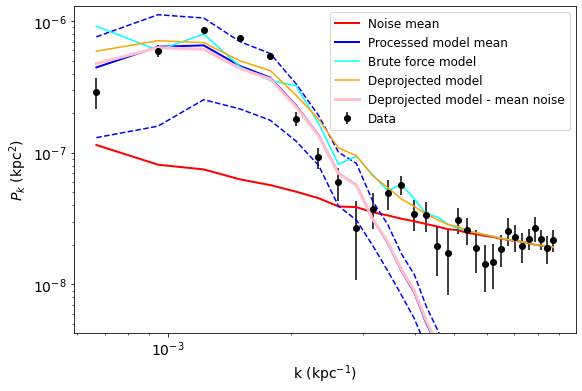

In [86]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 6))

plt.errorbar(k2d.to_value(unit+'-1'), pk2d_data.to_value(unit+'2'), 
             np.diag(pk2d_noisecovmat.to_value(unit+'4'))**0.5, marker='o', ls='', color='k', label='Data')
plt.plot(k2d.to_value(unit+'-1'), pk2d_noise.to_value(unit+'2'), color='red', lw=2, label='Noise mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2'), color='blue', lw=2, label='Processed model mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') + np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') - np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_modbrute.to_value(unit+'2'), color='cyan', label='Brute force model')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_moddeproj.to_value(unit+'2'), color='orange', label='Deprojected model')
plt.plot(k2d.to_value(unit+'-1'), (pk2d_test_moddeproj-pk2d_noise).to_value(unit+'2'), color='pink', lw=3, label='Deprojected model - mean noise')
plt.xscale('log')
plt.yscale('log')
plt.ylim(np.amax(pk2d_data.to_value(unit+'2'))*5e-3, np.amax(pk2d_data.to_value(unit+'2'))*1.5)
plt.xlabel('k ('+unit+'$^{-1}$)')
plt.ylabel(r'$P_k$ ('+unit+'$^{2}$)')
plt.legend(fontsize=12)

### Fitting for the profile

In [87]:
fitpar_prof = {'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
              'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]}}    

fitpar_ZL = {'ZL':{'guess':[0,1e-5],'unit':None}}

fitpar_ellipticity = {'min_to_maj_axis_ratio':{'guess':[1,0.1], 'unit':None, 'limit':[0,1]}, 
                      'angle':{'guess':[0,90], 'unit':u.deg, 'limit':[-90,90]}}

In [12]:
parlist, sampler = inference.fit_profile_forward(fitpar_prof,
                                                 #parinfo_ellipticity=fitpar_ellipticity,
                                                 #parinfo_ZL=fitpar_ZL, 
                                                 show_fit_result=False)

----- Existing sampler:
      /Users/adam/Desktop/pitszi_Mbb//pitszi_MCMC_profile_sampler.h5
----- Fit parameters information -----
      - Fitted parameters:            
['P_0' 'r_p' 'ZL']
      - Starting point mean:          
[2.e-02 1.e+03 0.e+00]
      - Starting point dispersion :   
[1.e-03 1.e+03 1.e-05]
      - Minimal starting point:       
[  0.   0. -inf]
      - Maximal starting point:       
[inf inf inf]
      - Number of dimensions:         
3
----- Does the sampler already exist? -----
      - Yes, but reset the MCMC even though the sampler already exists
----- MCMC sampling -----
      - Runing 200 MCMC steps


 74%|███████▎  | 147/200 [01:36<00:34,  1.52it/s]

emcee: Exception while calling your likelihood function:[3.00235870e-02 8.88443840e+02 1.13577894e-06]emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params:

  params:   params:  params:emcee: Exception while calling your likelihood function:  [2.74065304e-02 1.02004731e+03 2.34664670e-07] 
[3.23114372e-02 8.18371813e+02 2.68846255e-06]
[3.03161846e-02 9.10886250e+02 9.60760292e-07]
  args:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:

   args:  args:

   args:  params:   params:[{'P_0': {'guess': [0.02, 0.001], 'unit': Unit("keV / cm3"), 'limit': [0, inf]}, 'r_p': {'guess': [1000, 1000], 'unit': Unit("kpc"), 'limit': [0, inf]}}, array([[1.72686940e-05, 1.74504478e-05, 1.69031931e-05, ...,
        1.70940552e-05, 1.67811539e-05, 1.77039516e-05],
       [1.74740770e-05, 1.68875224e-05, 1.66382746e-

KeyboardInterrupt: 

{} {}  exception:
{}  exception:



  exception:  exception:


[3.03123081e-02 8.82133746e+02 1.51550228e-06]  args:


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/inference_main.py", line 1569, in lnlike_profile_forward
    irfs_convolution_TF=data.transfer_function)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/inference_main.py", line 1569, in lnlike_profile_forward
    irfs_convolution_TF=data.transfer_function)
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/inference_main.py", line 1569, in lnlike_profile_forward
    irfs_convolution_TF=data.transfer_function)
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_mock.py", line 344, in get_sz_map
    pressure_profile_cube = self.get_pressure_cube_profile()
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7

  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_mock.py", line 164, in get_pressure_cube_profile
    map_center = self.get_map_center()
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/inference_main.py", line 1569, in lnlike_profile_forward
    irfs_convolution_TF=data.transfer_function)
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_mock.py", line 164, in get_pressure_cube_profile
    map_center = self.get_map_center()
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_mock.py", line 165, in get_pressure_cube_profile
    offset = (self._coord).transform_to(SkyOffsetFrame(origin=map_center))
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_sampling.py", line 167, in get_map_center
    ramap, decmap = map_tools.get_radec_map(header) # indexing is xy in this function


  args:

  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_mock.py", line 344, in get_sz_map
    pressure_profile_cube = self.get_pressure_cube_profile()
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordinates/sky_coordinate.py", line 620, in transform_to
    new_coord = trans(self.frame, generic_frame)
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_sampling.py", line 189, in get_map_center
    map_center = SkyCoord(ramap_center*u.deg, decmap_center*u.deg, frame='icrs')
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordinates/transformations.py", line 1391, in __call__
    curr_toframe = t.tosys(**frattrs)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py", line 179, in get_radec_map
    w = WCS(header)
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitsz

  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordinates/baseframe.py", line 297, in getter
    def getter(self):
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/wcs/wcs.py", line 473, in __init__
    header_string = header.tostring()


  args:

KeyboardInterrupt
Process ForkPoolWorker-1:
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/io/fits/header.py", line 684, in tostring
    s = str(card)
KeyboardInterrupt
Process ForkPoolWorker-6:
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/io/fits/card.py", line 205, in __str__
    return self.image
Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/io/fits/card.py", line 521, in image
    self.verify('fix+warn')
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/io/fits/verify.py", line 73, in verify
    errs = self._verify(opt)
  File "/Users/adam/Project/anacond

  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/multiprocess/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/multiprocess/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
Traceback (most recent call last):
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File 

[{'P_0': {'guess': [0.02, 0.001], 'unit': Unit("keV / cm3"), 'limit': [0, inf]}, 'r_p': {'guess': [1000, 1000], 'unit': Unit("kpc"), 'limit': [0, inf]}}, array([[1.72686940e-05, 1.74504478e-05, 1.69031931e-05, ...,
        1.70940552e-05, 1.67811539e-05, 1.77039516e-05],
       [1.74740770e-05, 1.68875224e-05, 1.66382746e-05, ...,
        1.62739193e-05, 1.68846211e-05, 1.76165147e-05],
       [1.71095581e-05, 1.65483950e-05, 1.59831184e-05, ...,
        1.63789915e-05, 1.71961784e-05, 1.69373735e-05],
       ...,
       [1.72004475e-05, 1.69128796e-05, 1.68662064e-05, ...,
        1.60275246e-05, 1.61195226e-05, 1.61869846e-05],
       [1.76592375e-05, 1.70226530e-05, 1.69232694e-05, ...,
        1.65522622e-05, 1.71901105e-05, 1.70737529e-05],
       [1.77920562e-05, 1.77567590e-05, 1.70476620e-05, ...,
        1.75686160e-05, 1.72455548e-05, 1.79535821e-05]]), None, None, {'ZL': {'guess': [0, 1e-05], 'unit': None}}, False]

  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/multiprocess/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordinates/sky_coordinate.py", line 316, in __init__
    frame_cls(**frame_kwargs), args, kwargs)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordinates/sky_coordinate.py", line 620, in transform_to
    new_coord = trans(self.frame, generic_frame)
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_sampling.py", line 167, in get_map_center
    ramap, decmap = map_tools.get_radec_map(header) # indexing is xy in this function
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordin

[{'P_0': {'guess': [0.02, 0.001], 'unit': Unit("keV / cm3"), 'limit': [0, inf]}, 'r_p': {'guess': [1000, 1000], 'unit': Unit("kpc"), 'limit': [0, inf]}}, array([[1.72686940e-05, 1.74504478e-05, 1.69031931e-05, ...,
        1.70940552e-05, 1.67811539e-05, 1.77039516e-05],
       [1.74740770e-05, 1.68875224e-05, 1.66382746e-05, ...,
        1.62739193e-05, 1.68846211e-05, 1.76165147e-05],
       [1.71095581e-05, 1.65483950e-05, 1.59831184e-05, ...,
        1.63789915e-05, 1.71961784e-05, 1.69373735e-05],
       ...,
       [1.72004475e-05, 1.69128796e-05, 1.68662064e-05, ...,
        1.60275246e-05, 1.61195226e-05, 1.61869846e-05],
       [1.76592375e-05, 1.70226530e-05, 1.69232694e-05, ...,
        1.65522622e-05, 1.71901105e-05, 1.70737529e-05],
       [1.77920562e-05, 1.77567590e-05, 1.70476620e-05, ...,
        1.75686160e-05, 1.72455548e-05, 1.79535821e-05]]), None, None, {'ZL': {'guess': [0, 1e-05], 'unit': None}}, False]

  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordinates/sky_coordinate_parsers.py", line 609, in _get_representation_attrs
    diff_attr_class = differential_type.attr_classes[repr_name]
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordinates/builtin_frames/skyoffset.py", line 178, in __init__
    super().__init__(*args, **kwargs)
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/inference_main.py", line 1569, in lnlike_profile_forward
    irfs_convolution_TF=data.transfer_function)


KeyboardInterrupt
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/wcs/wcs.py", line 520, in __init__
    self._get_naxis(header)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordinates/baseframe.py", line 476, in __init__
    elif self.representation_type:
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_mock.py", line 344, in get_sz_map
    pressure_profile_cube = self.get_pressure_cube_profile()


[{'P_0': {'guess': [0.02, 0.001], 'unit': Unit("keV / cm3"), 'limit': [0, inf]}, 'r_p': {'guess': [1000, 1000], 'unit': Unit("kpc"), 'limit': [0, inf]}}, array([[1.72686940e-05, 1.74504478e-05, 1.69031931e-05, ...,
        1.70940552e-05, 1.67811539e-05, 1.77039516e-05],
       [1.74740770e-05, 1.68875224e-05, 1.66382746e-05, ...,
        1.62739193e-05, 1.68846211e-05, 1.76165147e-05],
       [1.71095581e-05, 1.65483950e-05, 1.59831184e-05, ...,
        1.63789915e-05, 1.71961784e-05, 1.69373735e-05],
       ...,
       [1.72004475e-05, 1.69128796e-05, 1.68662064e-05, ...,
        1.60275246e-05, 1.61195226e-05, 1.61869846e-05],
       [1.76592375e-05, 1.70226530e-05, 1.69232694e-05, ...,
        1.65522622e-05, 1.71901105e-05, 1.70737529e-05],
       [1.77920562e-05, 1.77567590e-05, 1.70476620e-05, ...,
        1.75686160e-05, 1.72455548e-05, 1.79535821e-05]]), None, None, {'ZL': {'guess': [0, 1e-05], 'unit': None}}, False]

  kwargs:  kwargs:
  params:  {}  kwargs:
 [3.04909422e-02 

Traceback (most recent call last):


  kwargs:


  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/inference_main.py", line 1569, in lnlike_profile_forward
    irfs_convolution_TF=data.transfer_function)


{}


  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_mock.py", line 376, in get_sz_map
    apps_TF_LS=apps_TF_LS, apps_beam=apps_beam)


  exception:

  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_pk.py", line 145, in apply_transfer_function
    map_filt = np.real(np.fft.ifft2(FT_map_sm * filtering))
Traceback (most recent call last):


  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_mock.py", line 164, in get_pressure_cube_profile
    map_center = self.get_map_center()
  File "<__array_function__ internals>", line 6, in ifft2
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/numpy/fft/_pocketfft.py", line 1032, in ifft2
    return _raw_fftnd(a, s, axes, ifft, norm)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/numpy/fft/_pocketfft.py", line 652, in _raw_fftnd
    a = function(a, n=s[ii], axis=axes[ii], norm=norm)
Traceback (most recent call last):
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/wcs/wcs.py", line 2733, in _get_naxis
    _naxis.append(header[f'NAXIS{naxis}'])
  File "/Users/adam/Project/NIKA/Software/

  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/utils/decorators.py", line 769, in __set__
    ret = self.fset(obj, val)
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/model_mock.py", line 376, in get_sz_map
    apps_TF_LS=apps_TF_LS, apps_beam=apps_beam)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/io/fits/hdu/image.py", line 285, in data
    self.update_header()
KeyboardInterrupt
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/units/core.py", line 2174, in decompose
    if len(bases) == 0 and self._decomposed_cache is not None:
  File "/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_pk.py", line 145, in apply_transfer_function
    map_filt = np.real(np.fft.ifft2(FT_map_sm * filtering))
Process ForkPoolWorker-8:
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/io/fits/h

  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/io/fits/card.py", line 478, in field_specifier
    @property
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/multiprocess/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordinates/transformations.py", line 1310, in __call__
    M = self.matrix_func(fromcoord, toframe)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/multiprocess/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/units/quantity.py", line 457, in __array_ufunc__
    converters, unit = converters_and_unit(function, method, *inputs)
  File "/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/coordinates/builtin_frames/skyoffset.py", line 93, in refe

In [ ]:
~1 it /s at best reached

In [ ]:
#inference.setup()

In [ ]:
from pathos.multiprocessing import ProcessPool
pool = ProcessPool()
pool

In [ ]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    #'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],               
              }
fitpar_noise = {'ampli':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]}}

In [ ]:
inference.test_mcmc(fitpar_pk3d)
#pitszi.inference_main.test_mcmc(inference, fitpar_pk3d)

In [ ]:
100 walkers, pathos para, out --> 1.64 s/it
100 walkers, std para, out    --> 1.64 s/it
100 walkers, 0 para, out      --> 10.32 s/it


100 walkers, pathos para, in --> 1.64
100 walkers, std para, in    --> 1.63
100 walkers, 0 para, in      --> 10.33

100 walkers, pathos para, with self --> 1.70 s/it
100 walkers, std para, with self    --> fail
100 walkers, 0 para, with self      --> 10.29

100 walkers, pathos para, with self and lnlike self --> 1.69 s/it
100 walkers, std para, with self and lnlike self    --> fail
100 walkers, 0 para, with self  and lnlike self     --> 10.29

In [ ]:
img, _, _ = inference.get_image_data()
plt.imshow(img)
plt.colorbar()

In [ ]:
from scipy.optimize import curve_fit

k_mod, pk_mod, pk_mod_cov = inference.get_pk2d_modelvar_statistics(Nmc=100)
k_noi, pk_noi, pk_noi_cov = inference.get_pk2d_noise_statistics(Nmc=100)
k_dat, pk_dat = inference.get_pk2d_data()

def fitfunc(x, par1, par2, par3):
    inference.model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                                  'Norm': fluct_norm*par1, 
                                                  'slope': fluct_slope,
                                                  'Linj': fluct_linj*par2,
                                                  'Ldis': 1*u.kpc}
    k_test, pk_test = inference.modelpred_fluct_deproj_forward(physical=False)
    return pk_test.to_value('arcsec2') + par3*pk_noi.to_value('arcsec2')

popt, pcov = curve_fit(fitfunc, 0, pk_dat.to_value('arcsec2'),
                       p0=[1,1,1], sigma=(np.diag(pk_noi_cov)**0.5).to_value('arcsec2'))

In [ ]:
print(popt)
print(np.diag(pcov)**0.5)
print(pitszi.utils.correlation_from_covariance(pcov))
inference.model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                              'Norm': fluct_norm*popt[0], 
                                              'slope': fluct_slope,
                                              'Linj': fluct_linj*popt[1],
                                              'Ldis': 1*u.kpc}
k_best, pk_best = inference.modelpred_fluct_deproj_forward(physical=False)

plt.errorbar(k_dat.value, pk_dat.value, np.diag(pk_noi_cov.value)**0.5)
plt.loglog(k_best, pk_best + popt[2]*pk_noi)
plt.loglog(k_best, pk_best)
plt.loglog(k_best, popt[2]*pk_noi)
plt.ylim(np.amax(pk_dat.value+np.diag(pk_noi_cov.value)**0.5)*1e-2, 
         np.amax(pk_dat.value+np.diag(pk_noi_cov.value)**0.5)*1.5)

# Fit the fluctuation parameters: deprojection

In [ ]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    #'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],               
              }
fitpar_noise = {'ampli':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]}}

In [ ]:
fitpar, sampler = inference.fit_fluct_deproj_forward(fitpar_pk3d,
                                                     parinfo_noise=fitpar_noise, 
                                                     Nmc_noise=100,
                                                     use_covmat=False)

In [ ]:
inference.get_mcmc_chains_outputs_results(fitpar, sampler, extraname='_Pk_deproj')

In [ ]:
in

# Fit the fluctuation parameters: brute force